In [ ]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/taehwan/micromamba/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def ploting(fedavg, fedprox, fedref, title="MNIST Classification", metric="loss", num=60, thresholds=[0.5,0.7,1]):
    # 예시 데이터
    fedref_colors = ["blue", "orange", "green", "lightcoral", "darkred", "tomato", "red", "khaki", "darkkhaki"]
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(fedavg[metric][:num], marker=".",linestyle="--",label="fedavg", color=fedref_colors[0], alpha=1, linewidth=4)
    ax.plot(fedprox[metric][:num], marker=".", linestyle="--" ,label="fedprox(μ:0.5)", color=fedref_colors[1], alpha=1, linewidth=4)
    for i,l in enumerate(fedref):
        ax.plot(l[metric][:num], marker=".", label=l["label"], color=fedref_colors[i+2], linestyle="--", alpha=0.7, linewidth=4)

    # 메인 축 설정
    ax.set_xlabel("Rounds", fontsize=15)
    if metric=="mHF95":
        ax.set_ylabel(f"HF95", fontsize=15)
    elif metric=="mDice":
        ax.set_ylabel(f"DC", fontsize=15)
    elif metric=="loss":
        ax.set_ylabel(f"AsymmLoss", fontsize=15)
    elif metric=="accuracy":
        ax.set_ylabel(f"Accuracy", fontsize=15)
    elif metric=="f1score":
        ax.set_ylabel(f"F1Score", fontsize=15)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    # ax.legend(fontsize=15)
    fig.show()

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_ylabel("Rounds", fontsize=15)
    if metric=="mHF95":
        ax.set_xlabel(f"HF95-Thresholds", fontsize=15)
    elif metric=="mDice":
        ax.set_xlabel(f"DC-Thresholds", fontsize=15)
    elif metric=="loss":
        ax.set_xlabel(f"AsymmLoss-Thresholds", fontsize=15)
    elif metric=="accuracy":
        ax.set_xlabel(f"Accuracy-Thresholds", fontsize=15)
    elif metric=="f1score":
        ax.set_xlabel(f"F1Score-Thresholds", fontsize=15)
    # ax.set_yticks([i for i in np.arange(0, 2*num+1, step=num) if i!=2*num], labels= [i if i!=2*num else "No reach" for i in range(0, 2*num+1, num) if i!=2*num], fontsize=15)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    if metric=="loss" or metric=="mHF95":
        for i,t in enumerate(thresholds):
            samples = {"v":[(fedavg[metric]<=t).tolist().index(True) if (fedavg[metric]<=t).any() else len(fedavg[metric])+num,(fedprox[metric]<=t).tolist().index(True) if (fedprox[metric]<=t).any() else len(fedprox[metric])+100,
                                       *list(map(lambda x: (x[metric]<=t).tolist().index(True) if (x[metric]<=t).any() else len(x[metric])+100, fedref))], "colors":fedref_colors}
            S=list(zip(samples["v"], samples["colors"]))
            # S=sorted(S, key=lambda x: x[0], reverse=True)
            for idx, s in enumerate(S):
                plt.bar(i+idx*0.1-0.3, height=s[0], color =s[1], width=0.1, alpha=0.7)
        ax.set_xticks(range(len(thresholds)), [str(round(thresholds[len(thresholds)-i], 4)) for i in range(len(thresholds),0, -1)])
    else:
        for i,t in enumerate(thresholds):
            samples = {"v":[(fedavg[metric]>=t).tolist().index(True) if (fedavg[metric]>=t).any() else len(fedavg[metric])+num,(fedprox[metric]>=t).tolist().index(True) if (fedprox[metric]>=t).any() else len(fedprox[metric])+100,
                                       *list(map(lambda x: (x[metric]>=t).tolist().index(True) if (x[metric]>=t).any() else len(x[metric])+100, fedref))], "colors":fedref_colors}
            S=list(zip(samples["v"], samples["colors"]))
            # S=sorted(S, key=lambda x: x[0], reverse=True)
            for idx, s in enumerate(S):
                plt.bar(i+idx*0.1-0.3, height=s[0], color =s[1], width=0.1, alpha=0.7)
        ax.set_xticks(range(len(thresholds)), [str(round(thresholds[len(thresholds)-i]*100, 4))+"%" for i in range(len(thresholds),0, -1)])
    h,l =ax.get_legend_handles_labels()
    l.append("fedavg")
    l.append("fedprox(μ:0.5)")
    for ref in fedref:
        l.append(ref["label"])
    h.extend([plt.Line2D([0], [0], color=fedref_colors[0], lw=4), plt.Line2D([0], [0], color=fedref_colors[1], lw=4)])
    for i in range(len(fedref)):
        h.append(plt.Line2D([0], [0], color=fedref_colors[i+2], lw=4))
    # ax.legend(h, l, fontsize=15)
    fig.show()

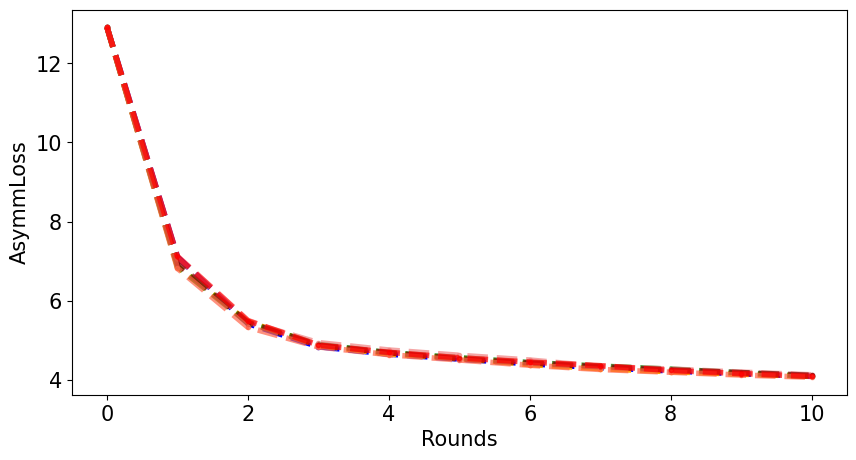

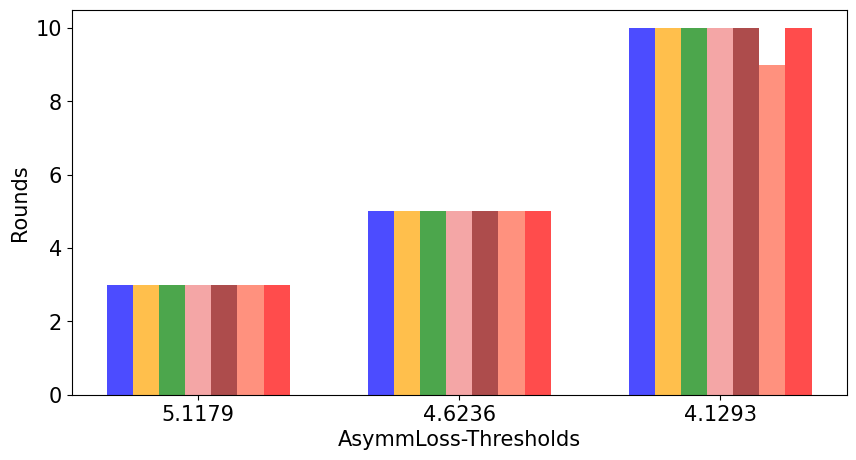

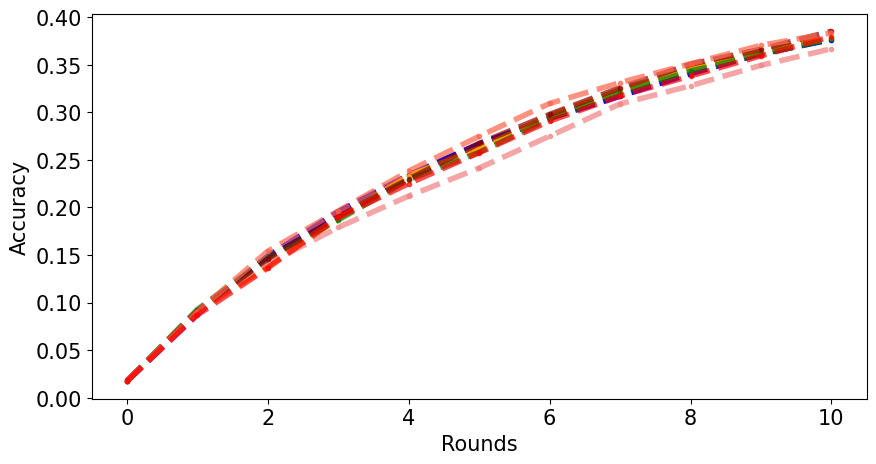

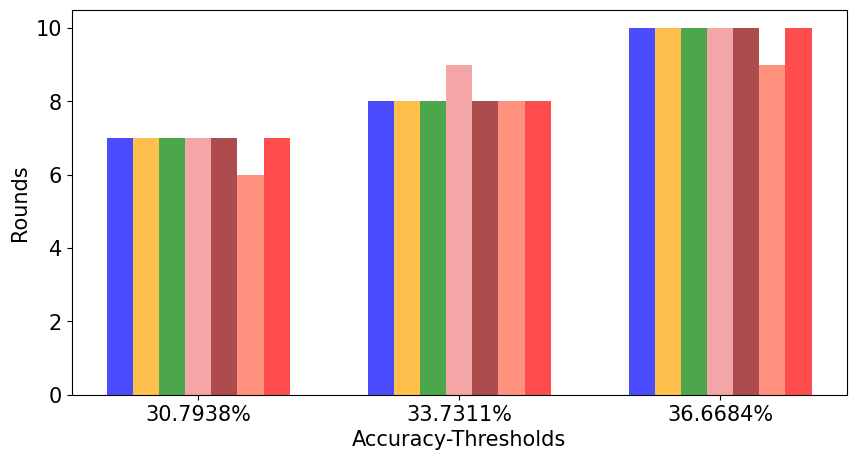

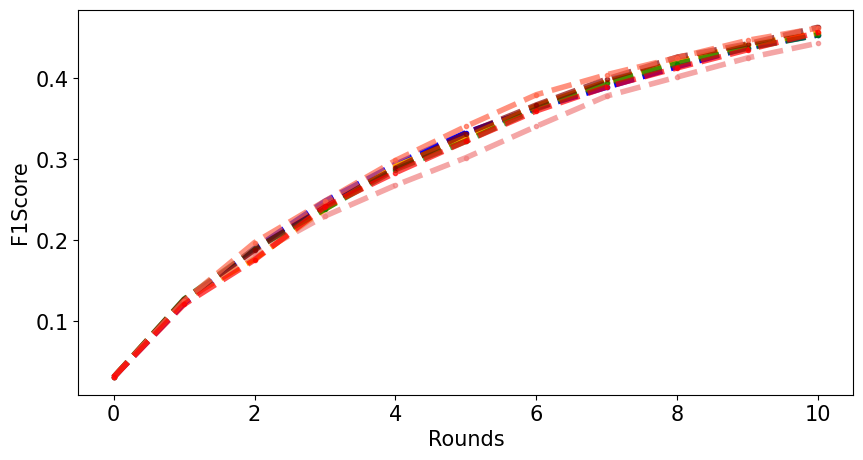

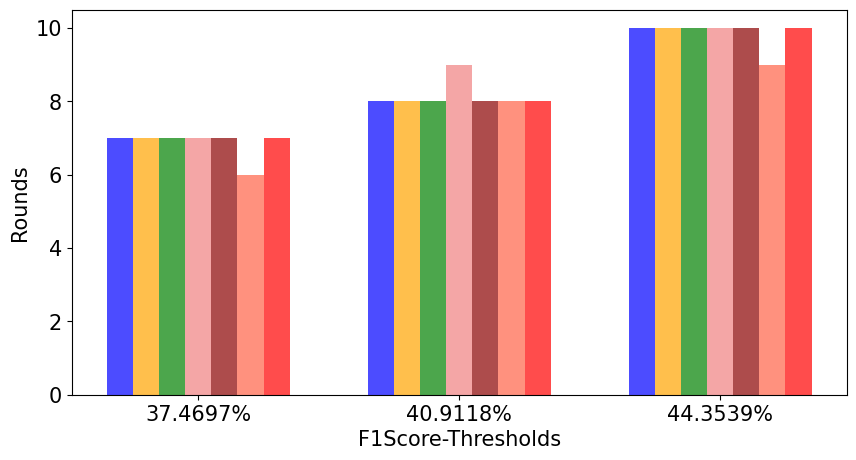

In [7]:
n =11
fedavg = pd.read_csv("Result/fedavg/fedavg_femnist.csv")
fedprox = pd.read_csv("Result/fedprox/fedprox_femnist.csv")
fedopt = pd.read_csv("Result/fedopt/fedopt_femnist.csv")
fedref = [{**fedopt.to_dict("series"), **{"label":"fedopt(η:0.01, β1:0.9, β2:0.99, τ:1e-4)"}},
    {**pd.read_csv("./Result/fedref/fedref_femnist_lda11.0_p1.csv").to_dict("series"), **{"label":"fedref(λg:0.1, ρ:1)"}},
    {**pd.read_csv("./Result/fedref/fedref_femnist_lda11.0_p3.csv").to_dict("series"), **{"label":"fedref(λg:0.1, ρ:3)"}},
    {**pd.read_csv("./Result/fedref/fedref_femnist_lda11.0_p5.csv").to_dict("series"), **{"label":"fedref(λg:0.1, ρ:5)"}},
    {**pd.read_csv("./Result/fedref/fedref_femnist_lda11.0_p7.csv").to_dict("series"), **{"label":"fedref(λg:0.1, ρ:7)"}}
    ]
loss_std = max([fedavg["loss"][:n].min()]+[fedprox["loss"][:n].min()]+[min(l["loss"][:n]) for i,l in enumerate(fedref)])
loss_std2 = abs(sum([l["loss"].std() for i,l in enumerate(fedref)])/(len(fedref)))
acc_std = min([fedavg["accuracy"][:n].max()]+[fedprox["accuracy"][:n].max()]+[l["accuracy"][:n].max() for i,l in enumerate(fedref)])
acc_std2 = abs(sum([l["accuracy"][:n].std() for i,l in enumerate(fedref)])/(len(fedref)))
f1_score_std = abs(sum([l["f1score"][:n].std() for i,l in enumerate(fedref)])/(len(fedref)))
f1_score_std2 = min([fedavg["f1score"][:n].max()]+[fedprox["f1score"][:n].max()]+[l["f1score"][:n].max() for i,l in enumerate(fedref)])
# f1_score_std2 = abs(sum([l["f1score"][:n].std() for i,l in enumerate(fedref) if i!=0])/(len(fedref)+2))
# print(acc_std, acc_std2)
# print(f1_score_std, f1_score_std2)
ploting(fedavg, fedprox, fedref, title="FEMNIST Classification", metric="loss", num=n, thresholds=[loss_std+0.5*loss_std2, loss_std+0.25*loss_std2, loss_std])
ploting(fedavg, fedprox, fedref, title="FEMNIST Classification", metric="accuracy", num=n, thresholds=[acc_std-0.5*acc_std2, acc_std-0.25*acc_std2, acc_std])
ploting(fedavg, fedprox, fedref, title="FEMNIST Classification", metric="f1score", num=n, thresholds=[f1_score_std2-0.5*f1_score_std, f1_score_std2-0.25*f1_score_std, f1_score_std2])

In [4]:
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
def whole_forgetting(fedavg, fedprox, fedopt, fedref, metrics=["loss"], num=60):
    tableau_colors  = ["blue", "orange", "green", "lightcoral", "darkred", "tomato", "red", "khaki", "darkkhaki"]
    fig, ax = plt.subplots(figsize=(10, 5))
    bar_fig, bar_ax = plt.subplots(figsize=(10, 5))
    dictionary = {"updatable":{"fedavg":0,"fedprox":0,"fedopt":0, **{f"fedref{i+1}":0 for i in range(len(fedref))}}, 
                  "forgetting":{"fedavg":0,"fedprox":0,"fedopt":0, **{f"fedref{i+1}":0 for i in range(len(fedref))}},
                  "count":{"fedavg":0,"fedprox":0,"fedopt":0, **{f"fedref{i+1}":0 for i in range(len(fedref))}},
                  "array":{"fedavg":np.zeros_like(fedavg["loss"][:num]),"fedprox":np.zeros_like(fedprox["loss"][:num]),"fedopt":np.zeros_like(fedopt["loss"][:num]),
                           **{f"fedref{i+1}":np.zeros_like(fedref[i]["loss"][:num]) for i in range(len(fedref))}}}
    fedavg = fedavg[:num]
    fedprox = fedprox[:num]
    fedopt = fedopt[:num]
    for metric in metrics:
        if metric=="mHF95" or metric=="loss":
            fedavg_forgetting_count = ((fedavg[metric].values-fedavg[metric].values[-1])<0).sum()
            fedavg_forgetting = (fedavg[metric].values-fedavg[metric].values[-1])[(fedavg[metric].values-fedavg[metric].values[-1])<0].sum()
            fedavg_updatable = (fedavg[metric].values-fedavg[metric].values[-1])[(fedavg[metric].values-fedavg[metric].values[-1])>=0].sum()
            dictionary["array"]["fedavg"] += (fedavg[metric].values-fedavg[metric].values[-1])
            dictionary["updatable"]["fedavg"]+=fedavg_updatable
            dictionary["forgetting"]["fedavg"]+=fedavg_forgetting
            dictionary["count"]["fedavg"]+=fedavg_forgetting_count
            fedprox_forgetting_count = ((fedprox[metric].values-fedprox[metric].values[-1])<0).sum()
            fedprox_forgetting = (fedprox[metric].values-fedprox[metric].values[-1])[(fedprox[metric].values-fedprox[metric].values[-1])<0].sum()
            fedprox_updatable = (fedprox[metric].values-fedprox[metric].values[-1])[(fedprox[metric].values-fedprox[metric].values[-1])>=0].sum()
            dictionary["array"]["fedprox"] += (fedprox[metric].values-fedprox[metric].values[-1])
            dictionary["updatable"]["fedprox"]+=fedprox_updatable
            dictionary["forgetting"]["fedprox"]+=fedprox_forgetting
            dictionary["count"]["fedprox"]+=fedprox_forgetting_count
            fedopt_forgetting_count = ((fedopt[metric].values-fedopt[metric].values[-1])<0).sum()
            fedopt_forgetting = (fedopt[metric].values-fedopt[metric].values[-1])[(fedopt[metric].values-fedopt[metric].values[-1])<0].sum()
            fedopt_updatable = (fedopt[metric].values-fedopt[metric].values[-1])[(fedopt[metric].values-fedopt[metric].values[-1])>=0].sum()
            dictionary["array"]["fedopt"] += (fedopt[metric].values-fedopt[metric].values[-1])
            dictionary["count"]["fedopt"]+=fedopt_forgetting_count
            dictionary["updatable"]["fedopt"]+=fedopt_updatable
            dictionary["forgetting"]["fedopt"]+=fedopt_forgetting
            for i,l in enumerate(fedref):
                forgetting_count = ((l[metric][:num].values-l[metric][:num].values[-1])<0).sum()
                forgetting= (l[metric][:num].values-l[metric][:num].values[-1])[(l[metric][:num].values-l[metric][:num].values[-1])<0].sum()
                updatable = (l[metric][:num].values-l[metric][:num].values[-1])[(l[metric][:num].values-l[metric][:num].values[-1])>=0].sum()
                dictionary["array"][f"fedref{i+1}"] += (l[metric][:num].values-l[metric][:num].values[-1])
                dictionary["updatable"][f"fedref{i+1}"]+=updatable
                dictionary["forgetting"][f"fedref{i+1}"]+=forgetting
                dictionary["count"][f"fedref{i+1}"]+=forgetting_count
        else:
            fedavg_forgetting_count = ((fedavg[metric].values-fedavg[metric].values[-1])>0).sum()
            fedavg_forgetting = (fedavg[metric].values-fedavg[metric].values[-1])[(fedavg[metric].values-fedavg[metric].values[-1])>0].sum()
            fedavg_updatable = (fedavg[metric].values-fedavg[metric].values[-1])[(fedavg[metric].values-fedavg[metric].values[-1])<=0].sum()
            dictionary["array"]["fedavg"] += (fedavg[metric].values-fedavg[metric].values[-1])
            dictionary["updatable"]["fedavg"]+=fedavg_updatable
            dictionary["forgetting"]["fedavg"]+=fedavg_forgetting
            dictionary["count"]["fedavg"]+=fedavg_forgetting_count
            fedprox_forgetting_count = ((fedprox[metric].values-fedprox[metric].values[-1])>0).sum()
            fedprox_forgetting = (fedprox[metric].values-fedprox[metric].values[-1])[(fedprox[metric].values-fedprox[metric].values[-1])>0].sum()
            fedprox_updatable = (fedprox[metric].values-fedprox[metric].values[-1])[(fedprox[metric].values-fedprox[metric].values[-1])<=0].sum()
            dictionary["array"]["fedprox"] += (fedprox[metric].values-fedprox[metric].values[-1])
            dictionary["updatable"]["fedprox"]+=fedprox_updatable
            dictionary["forgetting"]["fedprox"]+=fedprox_forgetting
            dictionary["count"]["fedprox"]+=fedprox_forgetting_count
            fedopt_forgetting_count = ((fedopt[metric].values-fedopt[metric].values[-1])>0).sum()
            fedopt_forgetting = (fedopt[metric].values-fedopt[metric].values[-1])[(fedopt[metric].values-fedopt[metric].values[-1])>0].sum()
            fedopt_updatable = (fedopt[metric].values-fedopt[metric].values[-1])[(fedopt[metric].values-fedopt[metric].values[-1])<=0].sum()
            dictionary["array"]["fedopt"] += (fedopt[metric].values-fedopt[metric].values[-1])
            dictionary["count"]["fedopt"]+=fedopt_forgetting_count
            dictionary["updatable"]["fedopt"]+=fedopt_updatable
            dictionary["forgetting"]["fedopt"]+=fedopt_forgetting
            for i,l in enumerate(fedref):
                forgetting_count = ((l[metric][:num].values-l[metric][:num].values[-1])>0).sum()
                forgetting= (l[metric][:num].values-l[metric][:num].values[-1])[(l[metric][:num].values-l[metric][:num].values[-1])>0].sum()
                updatable = (l[metric][:num].values-l[metric][:num].values[-1])[(l[metric][:num].values-l[metric][:num].values[-1])<=0].sum()
                dictionary["array"][f"fedref{i+1}"] += (l[metric][:num].values-l[metric][:num].values[-1])
                dictionary["updatable"][f"fedref{i+1}"]+=updatable
                dictionary["forgetting"][f"fedref{i+1}"]+=forgetting
                dictionary["count"][f"fedref{i+1}"]+=forgetting_count

    print(pd.DataFrame(dictionary)[["count","forgetting", "updatable"]])
    ax.set_xlabel("Rounds",fontsize=15)
    if metric=="mHF95":
        ax.set_ylabel("HF95 Forgetting Measure (ψ)",fontsize=15)
    elif metric=="mDice":
        ax.set_ylabel("DC Forgetting Measure (ψ)",fontsize=15)
    elif metric=="loss":
        ax.set_ylabel("AsymmLoss Forgetting Measure (ψ)",fontsize=15)
    elif metric=="accuracy":
        ax.set_ylabel("Accuracy Forgetting Measure (ψ)",fontsize=15)
    elif metric=="f1score":
        ax.set_ylabel("F1Score Forgetting Measure (ψ)",fontsize=15)
    ax.tick_params(axis='x', labelsize=15)
    # ax.plot(np.linspace((dictionary["array"]["fedref2"][0]+dictionary["array"]["fedavg"][0])/2, 0, num), color="purple", alpha=0.5,linewidth=2)
    ax.plot(dictionary["array"]["fedavg"], label="FedAvg", color=tableau_colors[0], linestyle="--", alpha=1,linewidth=2)
    ax.plot(dictionary["array"]["fedprox"], label="FedProx", linestyle="--", color=tableau_colors[1], alpha=1, linewidth=2)
    ax.plot(dictionary["array"]["fedopt"], label="FedOpt", linestyle="--", color=tableau_colors[2], alpha=1, linewidth=2)
    for i,l in enumerate(fedref):
        ax.plot(dictionary["array"][f"fedref{i+1}"], label=l["label"], color=tableau_colors[i+3], alpha=1, linewidth=4)
    fig.show()
    bar_ax.tick_params(axis='x', labelsize=15)
    bar_ax.set_xlabel("Methods",fontsize=15)
    if metric=="mHF95":
        bar_ax.set_ylabel("HF95 Forgetting Measure (ζ)",fontsize=15)
    elif metric=="mDice":
        bar_ax.set_ylabel("DC Forgetting Measure (ζ)",fontsize=15)
    elif metric=="loss":
        bar_ax.set_ylabel("AsymmLoss Forgetting Measure (ζ)",fontsize=15)
    elif metric=="accuracy":
        bar_ax.set_ylabel("Accuracy Forgetting Measure (ζ)",fontsize=15)
    elif metric=="f1score":
        bar_ax.set_ylabel("F1Score Forgetting Measure (ζ)",fontsize=15)
    bar_ax.bar_label(bar_ax.bar(list(dictionary["count"].keys()) , [dictionary["updatable"]["fedavg"]+dictionary["forgetting"]["fedavg"],
                                                                                dictionary["updatable"]["fedprox"]+dictionary["forgetting"]["fedprox"],
                                                                                dictionary["updatable"]["fedopt"]+dictionary["forgetting"]["fedopt"],
                                                                                *[dictionary["updatable"][f"fedref{i+1}"]+dictionary["forgetting"][f"fedref{i+1}"] for i in range(len(fedref))],
                                                                                ]
                                                                                ,color=tableau_colors[:len(list(dictionary["count"].keys()))], alpha=1, width=0.4), fmt='%.4f', fontsize=15)
    bar_fig.show()

         count  forgetting  updatable
fedavg       0         0.0  -1.500976
fedprox      0         0.0  -1.519616
fedopt       0         0.0  -1.520966
fedref1      0         0.0  -1.526943
fedref2      0         0.0  -1.568997
fedref3      0         0.0  -1.501264
fedref4      0         0.0  -1.577842
         count  forgetting  updatable
fedavg       0         0.0  -1.713743
fedprox      0         0.0  -1.743282
fedopt       0         0.0  -1.728695
fedref1      0         0.0  -1.752386
fedref2      0         0.0  -1.785696
fedref3      0         0.0  -1.723247
fedref4      0         0.0  -1.793911


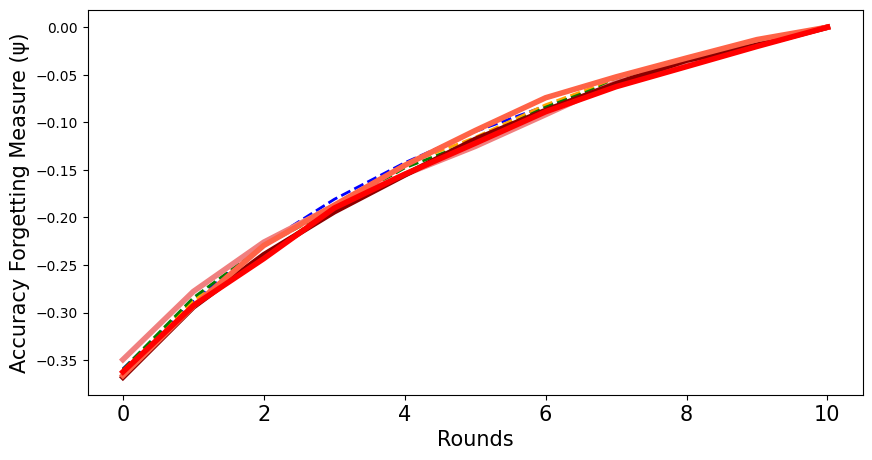

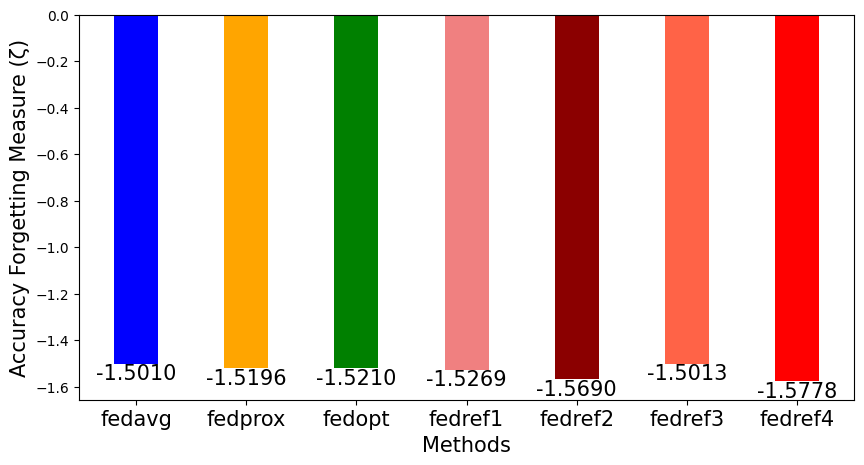

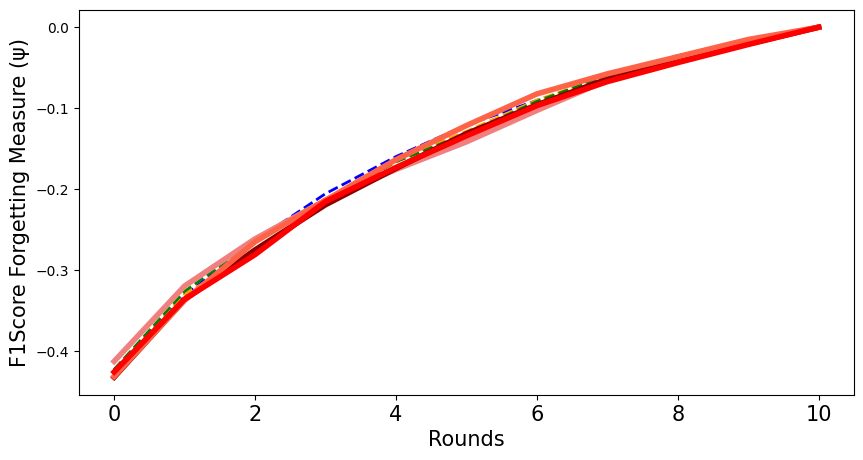

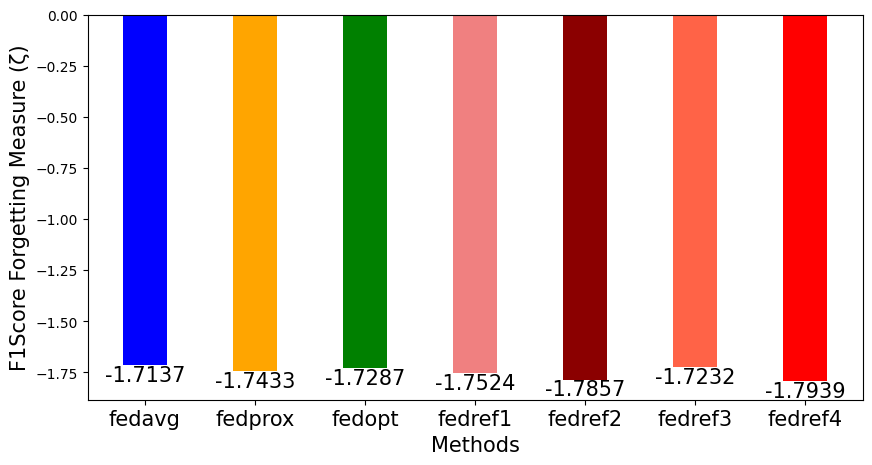

In [6]:
n =11
fedavg = pd.read_csv("Result/fedavg/fedavg_femnist.csv")
fedprox = pd.read_csv("Result/fedprox/fedprox_femnist.csv")
fedopt = pd.read_csv("Result/fedopt/fedopt_femnist.csv")
fedref = [
    {**pd.read_csv("./Result/fedref/fedref_femnist_lda11.0_p1.csv").to_dict("series"), **{"label":"fedref(λg:0.1, ρ:1)"}},
    {**pd.read_csv("./Result/fedref/fedref_femnist_lda11.0_p3.csv").to_dict("series"), **{"label":"fedref(λg:0.1, ρ:3)"}},
    {**pd.read_csv("./Result/fedref/fedref_femnist_lda11.0_p5.csv").to_dict("series"), **{"label":"fedref(λg:0.1, ρ:5)"}},
    {**pd.read_csv("./Result/fedref/fedref_femnist_lda11.0_p7.csv").to_dict("series"), **{"label":"fedref(λg:0.1, ρ:7)"}}
    ]
whole_forgetting(fedavg, fedprox, fedopt, fedref, metrics=["accuracy"], num=n)
whole_forgetting(fedavg, fedprox, fedopt, fedref, metrics=["f1score"], num=n)

In [10]:
n =11
fedavg = pd.read_csv("Result/fedavg/fedavg_femnist.csv")
fedprox = pd.read_csv("Result/fedprox/fedprox_femnist.csv")
fedopt = pd.read_csv("Result/fedopt/fedopt_femnist.csv")
fedref = [
    {**pd.read_csv("./Result/fedref/fedref_femnist_lda11.0_p1.csv").to_dict("series"), **{"label":"fedref(λg:0.1, ρ:1)"}},
    {**pd.read_csv("./Result/fedref/fedref_femnist_lda11.0_p3.csv").to_dict("series"), **{"label":"fedref(λg:0.1, ρ:3)"}},
    {**pd.read_csv("./Result/fedref/fedref_femnist_lda11.0_p5.csv").to_dict("series"), **{"label":"fedref(λg:0.1, ρ:5)"}},
    {**pd.read_csv("./Result/fedref/fedref_femnist_lda11.0_p7.csv").to_dict("series"), **{"label":"fedref(λg:0.1, ρ:7)"}}
    ]
print(max(fedavg["accuracy"][:n]))
print(max(fedprox["accuracy"][:n]))
print(max(fedopt["accuracy"][:n]))
print("-----")
print(max(fedref[0]["accuracy"][:n]))
print(max(fedref[1]["accuracy"][:n]))
print(max(fedref[2]["accuracy"][:n]))
print(max(fedref[3]["accuracy"][:n]))


0.3763441501703477
0.3778691112546992
0.3768943843984962
-----
0.3666835239955357
0.3851426662359022
0.3833341899671053
0.3795518459234023


In [11]:
print(max(fedavg["f1score"][:n]))
print(max(fedprox["f1score"][:n]))
print(max(fedopt["f1score"][:n]))
print("-----")
print(max(fedref[0]["f1score"][:n]))
print(max(fedref[1]["f1score"][:n]))
print(max(fedref[2]["f1score"][:n]))
print(max(fedref[3]["f1score"][:n]))

0.4537056050288458
0.4558719872833795
0.4536030821319801
-----
0.4435394992013314
0.4631239757848314
0.4621420705444999
0.456643501847674
